## 一、背景

随着电商平台的兴起，以及疫情的持续影响，线上购物在我们的日常生活中扮演着越来越重要的角色。在进行线上商品挑选时，评论往往是我们十分关注的一个方面。然而目前电商网站的评论质量参差不齐，甚至有水军刷好评或者恶意差评的情况出现，严重影响了顾客的购物体验。因此，对于评论质量的预测成为电商平台越来越关注的话题，如果能自动对评论质量进行评估，就能根据预测结果避免展现低质量的评论。本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。

## 二、任务

本案例中需要大家完成两种集成学习算法的实现（Bagging、AdaBoost.M1），其中基分类器要求使用 SVM 和决策树两种：

* Bagging + SVM
* Bagging + 决策树
* AdaBoost.M1 + SVM
* AdaBoost.M1 + 决策树

注意集成学习的核心算法需要**手动进行实现**，基分类器可以调库。

### 基本要求
* 根据数据格式设计特征的表示
* 汇报不同组合下得到的 AUC
* 结合不同集成学习算法的特点分析结果之间的差异
* （使用 sklearn 等第三方库的集成学习算法会酌情扣分）

### 扩展要求
* 尝试其他基分类器（如 k-NN、朴素贝叶斯）
* 分析不同特征的影响
* 分析集成学习算法参数的影响

## 三、评价指标
AUC ：https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics

## 四、数据概览

### 4.1 数据加载

本例数据来源于Amazon 现实场景中的真实评论。共三个文件: train.cvs为
训练集文件，test.cvs为测试集的特征文件，groundTruth.csv为测试集的标
签文件。分别用pandas导入:

In [2]:
import pandas as pd

train_df = pd.read_csv('./data/train.csv', sep='\t')            # 训练集
test_df = pd.read_csv('./data/test.csv', sep='\t')              # 测试集（特征）
test_df_y = pd.read_csv('./data/groundTruth.csv')               # 测试集（标签）

In [3]:
train_df                                                                                # 训练集 

,reviewerID,asin,reviewText,overall,votes_up,votes_all,label
0,7885,3901,"First off, allow me to correct a common mistak...",5.0,6,7,0
1,52087,47978,I am really troubled by this Story and Enterta...,3.0,99,134,0
2,5701,3667,A near-perfect film version of a downright glo...,4.0,14,14,1
3,47191,40892,Keep your expectations low. Really really low...,1.0,4,7,0
4,40957,15367,"""they dont make em like this no more...""well.....",5.0,3,6,0
...,...,...,...,...,...,...,...
57034,58315,29374,"If you like beautifully shot, well acted films...",2.0,12,21,0
57035,23328,45548,This is a great set of films Wayne did Fox and...,5.0,15,18,0
57036,27203,42453,It's what's known as a comedy of manners. It's...,3.0,4,5,0
57037,33992,44891,Ellen can do no wrong as far a creating wonder...,5.0,4,5,0


In [4]:
test_df                                                                                     # 测试集特征和内容 

,Id,reviewerID,asin,reviewText,overall
0,0,82947,37386,I REALLY wanted this series but I am in SHOCK ...,1.0
1,1,10154,23543,I have to say that this is a work of art for m...,4.0
2,2,5789,5724,Alien 3 is certainly the most controversal fil...,3.0
3,3,9198,5909,"I love this film...preachy? Well, of course i...",5.0
4,4,33252,21214,Even though I previously bought the Gamera Dou...,5.0
...,...,...,...,...,...
11203,11203,18250,35309,I honestly never heard of the graphic novel un...,5.0
11204,11204,3200,2130,Archie Bunker's command to stifle YOURSELF! wa...,5.0
11205,11205,37366,41971,"In LSD - My Problem Child, Albert Hoffman wrot...",5.0
11206,11206,1781,33089,I have owned this DVD for over a year now and ...,5.0


In [5]:
test_df_y                                                                                   # 测试集标签 

,Id,Expected
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
11203,11203,0
11204,11204,0
11205,11205,0
11206,11206,0


### 4.2 特征提取

 votes_up 和 votes_all只有训练集中出现，用来构造标签的输出。不考虑特提取。 reviewerID、asin与其它参数结合起来，可以用来分析和标注水军刷好评或者恶意差评的情况。reviewText是重要特征。SnowNLP

In [37]:


import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score,roc_curve, auc, accuracy_score
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from scipy.sparse import hstack
from snownlp import SnowNLP
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# 用户
train_reviewerID = MinMaxScaler().fit_transform(train_df['reviewerID'].values.reshape(-1, 1))
test_reviewerID = MinMaxScaler().fit_transform(test_df['reviewerID'].values.reshape(-1, 1))

# 商品
train_asin = MinMaxScaler().fit_transform(train_df['asin'].values.reshape(-1, 1))
test_asin = MinMaxScaler().fit_transform(test_df['asin'].values.reshape(-1, 1))

# 总评分
train_overall = train_df['overall'].values.reshape((-1, 1)) / 5
test_overall = test_df['overall'].values.reshape((-1, 1)) / 5 

# 情感
train_df['sentiments'] = train_df['reviewText'].map(lambda x: SnowNLP(x).sentiments)
train_df['sentiments'] = pd.cut(train_df['sentiments'].rank(method='first'), 5, labels=[-1, -0.5, 0, 0.5, 1])
train_sentiments = train_df['sentiments'].values.reshape((-1, 1))
test_df['sentiments'] = test_df['reviewText'].map(lambda x: SnowNLP(x).sentiments)
test_df['sentiments'] = pd.cut(test_df['sentiments'].rank(method='first'), 5, labels=[-1, -0.5, 0, 0.5, 1])
test_sentiments = test_df['sentiments'].values.reshape((-1, 1))

# 评论长度
train_df['keywords_len'] = train_df['reviewText'].map(lambda x: len(x.split(' ')))
train_df['keywords_len'] = pd.cut(train_df['keywords_len'].rank(method='first'), 5, labels=[0,0.25,0.5,0.75,1])
train_keywords_len = train_df['keywords_len'].values.reshape((-1, 1))
test_df['keywords_len'] = test_df['reviewText'].map(lambda x: len(x.split(' ')))
test_df['keywords_len'] = pd.cut(test_df['keywords_len'].rank(method='first'), 5, labels=[0,0.25,0.5,0.75,1])
test_keywords_len= test_df['keywords_len'].values.reshape((-1, 1))

# 文本预处理
def pretreatment_text(comment):
    # sens = sent_tokenize(comment)                                                     # 文本分句
    # word_tokens = [word_tokenize(s) for s in sens ]
    words = word_tokenize(comment)                                                      # 文本分词
    words = [SnowballStemmer('english').stem(y) for y in words]                         # 提取词干 
    # words = [WordNetLemmatizer().lemmatize(y) for y in words]                         # 词形还原   
    words = [w for w in words if not w in stopwords.words('english')]                   # 停用词 
    # return ' '.join(words)
    return words 

# tf/idf 处理文本特征
word_model = TfidfVectorizer()                # HashingVectorizer(tokenizer=pretreatment_text)
train_x = word_model.fit_transform(train_df['reviewText'])
test_x = word_model.transform(test_df['reviewText']) 

# 拼接特征
# train_x =hstack([train_x, train_overall, train_reviewerID, train_asin, train_sentiments, train_keywords_len])
# test_x = hstack([test_x, train_overall, test_reviewerID, test_asin, test_sentiments, test_keywords_len])
train_x =hstack([train_x, train_overall, train_asin, train_keywords_len])
test_x = hstack([test_x, test_overall, test_asin, test_keywords_len])

train_y = train_df['label']
test_y = test_df_y['Expected']

## 五、模型及调优

### 5.1 基础模型

#### 5.1.1 决策树

In [7]:
exec_result = pd.DataFrame(columns=['type','method','auc', 'fpr', 'tpr', 'accuracy','parameters'])

for max_depth in range(2, 13):                                                                    
    for criterion in ['gini','entropy']:
        for min_samples_split in range(200, 500, 25):
            clf = DecisionTreeClassifier(max_depth=max_depth, criterion = criterion, min_samples_split = min_samples_split)
            clf.fit(train_x.tocsr(), train_y)
            y_predict = clf.predict_proba(test_x)[:, 1]
            fpr_tree,tpr_tree,thresholds=roc_curve(test_y, y_predict)                               # 计算fpr、tpr的值
            auc_tree = roc_auc_score(test_y, y_predict)                                             # 计算auc的值
            accuracy_tree = accuracy_score(test_y, np.around(y_predict, 0).astype(int))             # 计算accuracy的值
            exec_result.loc[exec_result.shape[0]] = ['base', 'dtree', auc_tree, fpr_tree, tpr_tree, accuracy_tree, 'max_depth:' + str(max_depth) + '; criterion:' + criterion + '; min_samples_split:' + str(min_samples_split)]
            
best_index = exec_result.query("type=='base' & method=='dtree'")['auc'].idxmax()
auc_tree_best= exec_result.loc[best_index]
auc_tree_best

type                                                       base
method                                                    dtree
auc                                                    0.776377
fpr           [0.0, 0.0002206531332744925, 0.000551632833186...
tpr           [0.0, 0.0, 0.0009328358208955224, 0.0013992537...
accuracy                                               0.810939
parameters    max_depth:6; criterion:entropy; min_samples_sp...
Name: 3, dtype: object

In [8]:
auc_tree_best

type                                                       base
method                                                    dtree
auc                                                    0.776377
fpr           [0.0, 0.0002206531332744925, 0.000551632833186...
tpr           [0.0, 0.0, 0.0009328358208955224, 0.0013992537...
accuracy                                               0.810939
parameters    max_depth:6; criterion:entropy; min_samples_sp...
Name: 3, dtype: object

#### 5.1.2 朴素贝叶斯

In [9]:
for a in range(1,10):
    clf = BernoulliNB(alpha=a/100)
    clf.fit(train_x, train_y)
    y_predict = clf.predict_proba(test_x)[:,1]
    fpr_nb,tpr_nb,thresholds=roc_curve(test_y, y_predict)                                   # 计算fpr、tpr的值
    auc_nb = roc_auc_score(test_y, y_predict)                                               # 计算auc的值
    accuracy_nb = accuracy_score(test_y,np.around(y_predict, 0).astype(int))                # 计算accuracy的值
    exec_result.loc[exec_result.shape[0]] = ['base', 'nb', auc_nb, fpr_nb, tpr_nb, accuracy_nb, 'alpha:' + str(a/100)]
    
best_index = exec_result.query("type=='base' & method=='nb'")['auc'].idxmax()
auc_nb_best= exec_result.loc[best_index]
auc_nb_best

type                                                       base
method                                                       nb
auc                                                    0.727823
fpr           [0.0, 0.03287731685789938, 0.03398058252427184...
tpr           [0.0, 0.10587686567164178, 0.11007462686567164...
accuracy                                               0.753658
parameters                                           alpha:0.01
Name: 4, dtype: object

In [14]:
# exec_result = exec_result.drop(exec_result[exec_result['method']=='bn'].index)
# exec_result = exec_result.drop(exec_result[exec_result['method']=='knn'].index)
# exec_result = exec_result.drop(exec_result[exec_result['method']=='svm'].index)

#### 5.1.3  K近邻

In [10]:

for k in [1, 3, 5, 7, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101,                           # for k in list(range(1,10,2)) + list(range(11,200,10))  :  
        111, 121, 131, 141, 151, 161, 171, 181, 191]:   
    for w in ['uniform', 'distance']:
        clf = KNeighborsClassifier(n_neighbors=k, weights=w)
        clf.fit(train_x, train_y)
        y_predict = clf.predict_proba(test_x)[:,1]
        fpr_knn,tpr_knn,thresholds=roc_curve(test_y, y_predict)                             # 计算fpr、tpr的值
        auc_knn = roc_auc_score(test_y, y_predict)                                          # 计算auc的值
        accuracy_knn = accuracy_score(test_y, np.around(y_predict, 0).astype(int))          # 计算accuracy的值
        exec_result.loc[exec_result.shape[0]] = ['base', 'knn', auc_knn, fpr_knn, tpr_knn, accuracy_knn, 'n_neighbors:' + str(k) + '; weights:' + w]
            
best_index = exec_result.query("type=='base' & method=='knn'")['auc'].idxmax()
auc_knn_best= exec_result.loc[best_index]
auc_knn_best 

type                                                       base
method                                                      knn
auc                                                    0.795837
fpr           [0.0, 0.0, 0.0, 0.00011032656663724625, 0.0001...
tpr           [0.0, 0.0004664179104477612, 0.006063432835820...
accuracy                                                0.81424
parameters                    n_neighbors:101; weights:distance
Name: 6, dtype: object

In [11]:
# exec_result = exec_result.drop(exec_result[exec_result['method']=='knn'].index)

ra =exec_result.query("type=='base' & method=='knn'")
ra


,type,method,auc,fpr,tpr,accuracy,parameters
5,base,knn,0.794765,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000110326566637246...","[0.0, 0.0009328358208955224, 0.002798507462686...",0.81424,n_neighbors:101; weights:uniform
6,base,knn,0.795837,"[0.0, 0.0, 0.0, 0.00011032656663724625, 0.0001...","[0.0, 0.0004664179104477612, 0.006063432835820...",0.81424,n_neighbors:101; weights:distance


#### 5.1.4  支持向量机

In [12]:
for c in range(1,10):
    clf = LinearSVC(C=c, dual=False)
    clf.fit(train_x, train_y)
    y_predict = clf._predict_proba_lr(test_x)[:,1]
    fpr_svm,tpr_svm,thresholds=roc_curve(test_y, y_predict)                                 # 计算fpr、tpr的值
    auc_svm = roc_auc_score(test_y, y_predict)                                              # 计算auc的值
    accuracy_svm = accuracy_score(test_y, np.around(y_predict, 0).astype(int))              # 计算accuracy的值
    exec_result.loc[exec_result.shape[0]] = ['base', 'svm', auc_svm, fpr_svm, tpr_svm, accuracy_svm, 'C:' + str(c)]
            
best_index = exec_result.query("type=='base' & method=='svm'")['auc'].idxmax()
auc_svm_best= exec_result.loc[best_index]
auc_svm_best 

type                                                       base
method                                                      svm
auc                                                    0.792405
fpr           [0.0, 0.00011032656663724625, 0.00011032656663...
tpr           [0.0, 0.0, 0.0032649253731343282, 0.0032649253...
accuracy                                               0.809868
parameters                                                  C:1
Name: 7, dtype: object

### 5.2 Bagging


In [14]:
def bagging(clf, n_estimators, max_samples, train_X, train_Y, test_X, have_proba = True):
    '''
    clf:分类器；
    n_estimators: 采样次数；
    max_samples: 采样的最大样本数（样本充许重复）,
    train_X: 训练集特征
    train_Y: 训练集标签
    test_X: 测试集特征
    have_proba: 分类器是否有predict_proba方法。如果没有，使用_predict_proba_lr
    '''
    y_predict = np.zeros(test_X.shape[0])                                                           # 测试集预测结果
    for n in range(n_estimators):
        train_indexs = np.random.choice(np.arange(max_samples), size=max_samples, replace=True)     # 放回重取样max_samplesu次
        clf.fit( train_X[train_indexs], train_Y[train_indexs]  )    
        if have_proba:                                                                              # 累加预测结果
            y_predict += clf.predict_proba(test_X)[:, 1]                                            
        else:
            y_predict += clf._predict_proba_lr(test_X)[:, 1]                                          
    y_predict /= n_estimators                                                                       # 算术平均计算投票结果
    # y_predict = np.argmax(y_predict, axis=1)
    # y_predict = np.around(y_predict, 0).astype(int)
    return y_predict 

#### 5.2.1 决策树

In [15]:
np.random.seed(0)
clf = DecisionTreeClassifier(max_depth=6, criterion='entropy', min_samples_split=275)
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正

for n in range(2, 30):        
    for max in [5000, 10000, 20000, 30000, len(train_y)]: 
        y_predict = bagging(clf,n, max, train_x.tocsr(), train_y, test_x)
        print(y_predict)
        fpr_bagging_tree, tpr_bagging_tree, thresholds=roc_curve(test_y, y_predict)                 # 计算fpr、tpr的值
        auc_bagging_tree = roc_auc_score(test_y, y_predict)                                         # 计算auc的值 auc(fpr_bagging_tree, tpr_bagging_tree)
        accuracy_bagging_tree = accuracy_score(test_y,  np.around(y_predict, 0).astype(int))        # 计算accuracy的值
        exec_result.loc[exec_result.shape[0]] = ['bagging', 'tree', auc_bagging_tree, fpr_bagging_tree, tpr_bagging_tree, accuracy_bagging_tree, 'n_estimators:' + str(n) + '; max_samples:' + str(max)]
        print('auc:' + str(auc_bagging_tree) + '; n_estimators:' + str(n) + '; max_samples:' + str(max))
best_index = exec_result.query("type=='bagging' & method=='tree'")['auc'].idxmax()
auc_bagging_tree_best= exec_result.loc[best_index]
auc_bagging_tree_best

[0.10570429 0.25968711 0.10631068 ... 0.29118449 0.62043077 0.08444054]
auc:0.7779228100999854; n_estimators:21; max_samples:5000
[0.09275034 0.27158733 0.12008416 ... 0.27161783 0.6938193  0.07942331]
auc:0.781648801721753; n_estimators:21; max_samples:10000
[0.09313335 0.25849565 0.09520334 ... 0.29724987 0.59663263 0.07317406]
auc:0.7816553111950177; n_estimators:21; max_samples:20000
[0.07642983 0.21540089 0.13524258 ... 0.34071199 0.72193685 0.0685028 ]
auc:0.780829122673262; n_estimators:21; max_samples:30000
[0.08365526 0.23376951 0.09727399 ... 0.36382512 0.77345216 0.06219919]
auc:0.7846624305518963; n_estimators:21; max_samples:57039


type                                                    bagging
method                                                     tree
auc                                                    0.784662
fpr           [0.0, 0.00011032656663724625, 0.00011032656663...
tpr           [0.0, 0.0, 0.0018656716417910447, 0.0018656716...
accuracy                                                0.81076
parameters                   n_estimators:21; max_samples:57039
Name: 20, dtype: object

#### 5.2.2 朴素贝叶斯

In [16]:
np.random.seed(0)
clf =BernoulliNB(alpha=0.01)
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正

for n in [7]:        
    for max in [5000, 10000, 20000, 30000, len(train_y)]:
        y_predict = bagging(clf,n, max, train_x.tocsr(), train_y, test_x)
        fpr_bagging_nb,tpr_bagging_nb,thresholds=roc_curve(test_y, y_predict)                       # 计算fpr、tpr的值
        auc_bagging_nb = roc_auc_score(test_y, y_predict)                                           # 计算auc的值 auc(fpr_bagging_nb, tpr_bagging_nb)
        accuracy_bagging_nb = accuracy_score(test_y,  np.around(y_predict, 0).astype(int))          # 计算accuracy的值
        exec_result.loc[exec_result.shape[0]] = ['bagging', 'nb', auc_bagging_nb, fpr_bagging_nb, tpr_bagging_nb, accuracy_bagging_nb, 'n_estimators:' + str(n) + '; max_samples:' + str(max)]
        print('auc:' + str(auc_bagging_nb) + '; n_estimators:' + str(n) + '; max_samples:' + str(max))
best_index = exec_result.query("type=='bagging' & method=='nb'")['auc'].idxmax()
auc_bagging_nb_best= exec_result.loc[best_index]
auc_bagging_nb_best 

auc:0.7191604570236856; n_estimators:7; max_samples:5000
auc:0.7360312364150123; n_estimators:7; max_samples:10000
auc:0.730566675119548; n_estimators:7; max_samples:20000
auc:0.7300790563949889; n_estimators:7; max_samples:30000
auc:0.7235539912693812; n_estimators:7; max_samples:57039


type                                                    bagging
method                                                       nb
auc                                                    0.736031
fpr           [0.0, 0.0007722859664607238, 0.000992939099735...
tpr           [0.0, 0.005597014925373134, 0.0055970149253731...
accuracy                                               0.807994
parameters                    n_estimators:7; max_samples:10000
Name: 22, dtype: object

#### 5.2.3 K近邻

In [17]:
np.random.seed(0)
clf = KNeighborsClassifier(n_neighbors=101, weights='distance')
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正

for n in [range(2, 20)]:     
    for max in [5000, 10000, 20000, 30000, len(train_y)]:
        y_predict = bagging(clf,n, max, train_x.tocsr(), train_y, test_x)
        fpr_bagging_knn,tpr_bagging_knn,thresholds=roc_curve(test_y, y_predict)                     # 计算fpr、tpr的值
        auc_bagging_knn = roc_auc_score(test_y, y_predict)                                          # 计算auc的值 auc(fpr_bagging_knn, tpr_bagging_knn)
        accuracy_bagging_knn = accuracy_score(test_y, np.around(y_predict, 0).astype(int))          # 计算accuracy的值
        exec_result.loc[exec_result.shape[0]] = ['bagging', 'knn', auc_bagging_knn, fpr_bagging_knn, tpr_bagging_knn, accuracy_bagging_knn, 'n_estimators:' + str(n) + '; max_samples:' + str(max)]
        print('auc:' + str(auc_bagging_knn) + '; n_estimators:' + str(n) + '; max_samples:' + str(max))
best_index = exec_result.query("type=='bagging' & method=='knn'")['auc'].idxmax()
auc_bagging_knn_best= exec_result.loc[best_index]
auc_bagging_knn_best

auc:0.7680120984606974; n_estimators:3; max_samples:5000
auc:0.7778667720257934; n_estimators:3; max_samples:10000
auc:0.7814152840168092; n_estimators:3; max_samples:20000
auc:0.7845703459478863; n_estimators:3; max_samples:30000
auc:0.7929782183247488; n_estimators:3; max_samples:57039


type                                                    bagging
method                                                      knn
auc                                                    0.792978
fpr           [0.0, 0.0, 0.0, 0.00011032656663724625, 0.0001...
tpr           [0.0, 0.0004664179104477612, 0.004197761194029...
accuracy                                               0.807905
parameters                    n_estimators:3; max_samples:57039
Name: 30, dtype: object

#### 5.2.4 支持向量机

In [18]:

np.random.seed(0)
clf = LinearSVC(C=1,dual=False)
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正

for n in [range(2, 20)]:                                                                                # for n in range(5, 20, 2):
    for max in [5000, 10000, 20000, 30000, len(train_y)]:
        y_predict = bagging(clf,n, max, train_x.tocsr(), train_y, test_x)
        fpr_bagging_svm,tpr_bagging_svm,thresholds=roc_curve(test_y, y_predict)                     # 计算fpr、tpr的值
        auc_bagging_svm = roc_auc_score(test_y, y_predict)                                          # 计算auc的值 auc(fpr_bagging_svm, tpr_bagging_svm)
        accuracy_bagging_svm = accuracy_score(test_y, np.around(y_predict, 0).astype(int))          # 计算accuracy的值
        exec_result.loc[exec_result.shape[0]] = ['bagging', 'svm', auc_bagging_svm, fpr_bagging_svm, tpr_bagging_svm, accuracy_bagging_svm, 'n_estimators:' + str(n) + '; max_samples:' + str(max)]
        print('auc:' + str(auc_bagging_svm) + '; n_estimators:' + str(n) + '; max_samples:' + str(max))
best_index = exec_result.query("type=='bagging' & method=='svm'")['auc'].idxmax()
auc_bagging_svm_best= exec_result.loc[best_index]
auc_bagging_svm_best

auc:0.7862520027565174; n_estimators:6; max_samples:5000
auc:0.7952325544058173; n_estimators:6; max_samples:10000
auc:0.7962541557712322; n_estimators:6; max_samples:20000
auc:0.8007776479199324; n_estimators:6; max_samples:30000
auc:0.8060589147982505; n_estimators:6; max_samples:57039


type                                                    bagging
method                                                      svm
auc                                                    0.806059
fpr           [0.0, 0.0, 0.00011032656663724625, 0.000110326...
tpr           [0.0, 0.0004664179104477612, 0.000466417910447...
accuracy                                               0.821199
parameters                    n_estimators:6; max_samples:57039
Name: 35, dtype: object

### 5.3 Boosting

In [35]:
# AdaBoost.M1
def boosting(clf,n_estimators, train_X, train_Y, test_X, have_proba = True):
    '''
    采用AdaBoost.M1算法
    clf: 分类器;
    n_estimators: 迭代次数；
    train_X: 训练集特征
    train_Y: 训练集标签
    test_X: 测试集特征
    have_proba: 分类器是否有predict_proba方法。如果没有，使用_predict_proba_lr
    '''
    samples_count = len(train_Y)                                        # 样本数；也是样本初始总权重值
    assert samples_count == train_X.shape[0], "训练集的特征长度和标签长度不对应"

    results = list()                                                    # 所有轮的预测值
    Bts =list()                                                         # 所有轮的投票权重
    samples_weight = np.ones(samples_count)                             # 样本权重。每个样本初始权重为1。总和为样本总个数samples_count
    loop_couter =0                                                      # 用来记录投票权重趋势没有变化时的迭代次数 
    for i in range(n_estimators):
        clf.fit(train_X, train_Y)                                       
        train_y_predict = clf.predict(train_X)                          # 训练集的预测结果
        samples_error = train_y_predict != train_Y                      # 错误分类的样本位置
        e_t = samples_weight[samples_error].sum() / samples_count       # 错误率：所有错误分类的样本权重和（归一化）
        if e_t > 0.5 or loop_couter >1 or e_t==i==0:                    # e_t==i==0: 第一轮就错误率为0.                       
            break
        B_t = e_t / (1 - e_t)
        if e_t == 0.5 and B_t==1:                                       # e_t = 0.5 且B_t=1时，权重趋势没有变化。
            loop_couter +=1
        Bts.append(B_t)                                                 # 记录每i轮的投票权重
        print('n_estimators:{:<2d}; error:{:2f}; beta_t:{:2f}'.format(i, e_t, B_t))
        if have_proba:                                                  # 记录每i轮的预测值
            results.append( clf.predict_proba(test_X)[:, 1])         
        else:
            results.append( clf._predict_proba_lr(test_X)[:, 1])                    

        samples_weight *= (1.0 - samples_error) * B_t + samples_error   # 新样本权重 = 原正确分类*Bt + 原错误分类
        samples_weight /= samples_weight.sum() / samples_count          # 归一化，让权重和等于 num_samples

    Bts = np.log(1 / np.array(Bts))                                     # 各自投票权重为log[1/Bt]
    Bts /= Bts.sum() 
    print('beta_ts:\n', Bts)
    print('results:\n', results)
    results = (np.array(results) * Bts[:, None]).sum(0)                 # 预测的结果=所有轮的预测值*所有轮的投票权重
    # result = np.around(result,0).astype(int)                          # 预测的结果转为整数
    return results 

#### 5.3.1 决策树

In [29]:
clf = DecisionTreeClassifier(max_depth=6, criterion='entropy', min_samples_split=275)
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正
y_predict = boosting(clf,10, train_x.tocsr(), train_y, test_x)
fpr_boosting_tree, tpr_boosting_tree, thresholds=roc_curve(test_y, y_predict)                   # 计算fpr、tpr的值
auc_boosting_tree = roc_auc_score(test_y, y_predict)                                            # 计算auc的值 auc(fpr_boosting_tree, tpr_boosting_tree)
accuracy_boosting_tree = accuracy_score(test_y, np.around(y_predict, 0).astype(int))            # 计算accuracy的值
auc_boosting_tree 

n_estimators:0 ; error:0.215940; beta_t:0.275413
n_estimators:1 ; error:0.499875; beta_t:0.999501
n_estimators:2 ; error:0.498267; beta_t:0.993091
beta_ts:
 [9.94269655e-01 3.84636043e-04 5.34570859e-03]
results:
 [array([0.06390529, 0.17315915, 0.12727172, ..., 0.38731615, 0.84522493,
       0.06390529]), array([0.06395303, 0.17321297, 0.12732816, ..., 0.38733241, 0.8451216 ,
       0.06395303]), array([0.06366931, 0.17310099, 0.12715772, ..., 0.38772892, 0.84638418,
       0.06366931])]


0.77459083457931

#### 5.3.2 朴素贝叶斯

In [30]:
clf =BernoulliNB(alpha=0.01)
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正
y_predict = boosting(clf, 10, train_x.tocsr(), train_y, test_x)
fpr_boosting_nb,tpr_boosting_nb,thresholds=roc_curve(test_y, y_predict)                         # 计算fpr、tpr的值
auc_boosting_nb = roc_auc_score(test_y, y_predict)                                              # 计算auc的值 auc(fpr_boosting_nb, tpr_boosting_nb)
accuracy_boosting_nb = accuracy_score(test_y, np.around(y_predict, 0).astype(int))              # 计算accuracy的值
auc_boosting_nb 

n_estimators:0 ; error:0.226196; beta_t:0.292317
beta_ts:
 [1.]
results:
 [array([0.15767762, 0.15767762, 0.2786705 , ..., 0.40894742, 0.40894742,
       0.15767762])]


0.7272274954387375

#### 5.3.3 K近邻

In [ ]:
clf = KNeighborsClassifier(n_neighbors=101, weights='distance')
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正

y_predict = boosting(clf, 10, train_x.tocsr(), train_y, test_x)
fpr_boosting_knn,tpr_boosting_knn,thresholds=roc_curve(test_y, y_predict)                           # 计算fpr、tpr的值
auc_boosting_knn =  roc_auc_score(test_y, y_predict)                                                # 计算auc的值 auc(fpr_boosting_knn, tpr_boosting_knn)
accuracy_boosting_knn = accuracy_score(test_y, np.around(y_predict, 0).astype(int))                 # 计算accuracy的值
auc_boosting_knn 

#### 5.3.4 支持向量机

In [36]:
clf = LinearSVC(C=1, dual=False)
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正
y_predict = boosting(clf, 10, train_x.tocsr(), train_y, test_x)
fpr_boosting_svm,tpr_boosting_svm,thresholds=roc_curve(test_y, y_predict)                           # 计算fpr、tpr的值
auc_boosting_svm =  roc_auc_score(test_y, y_predict)                                                # 计算auc的值 auc(fpr_boosting_knn, tpr_boosting_knn)
accuracy_boosting_svm = accuracy_score(test_y, np.around(y_predict, 0).astype(int))                 # 计算accuracy的值

auc_boosting_svm

n_estimators:0 ; error:0.141184; beta_t:0.164394
beta_ts:
 [1.]
results:
 [array([0.15260473, 0.08459821, 0.17318018, ..., 0.32973116, 0.70743028,
       0.02403045])]


0.8026624105860811

## 六、小结

AUC对比

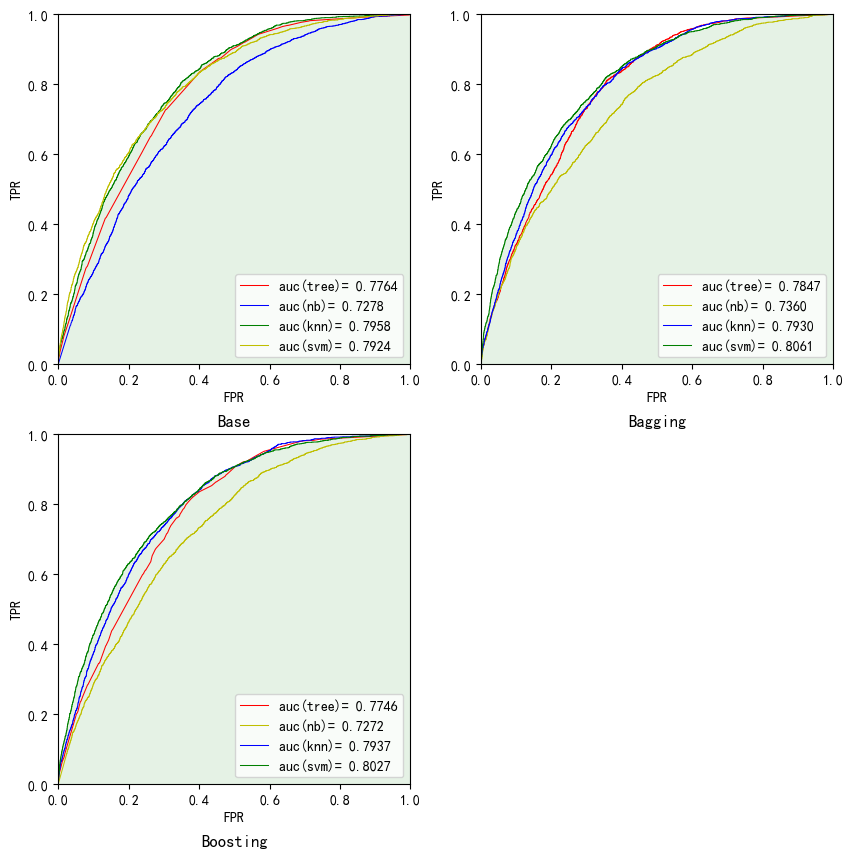

In [33]:
plt.figure(figsize=(10,10), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
ax_base = plt.subplot(221)
# ax_base.fill_between(auc_tree_best.fpr, auc_tree_best.tpr,y2=0, facecolor='r', alpha=0.1)
# ax_base.fill_between(auc_nb_best.fpr, auc_nb_best.tpr,y2=0, facecolor='b', alpha=0.4)
ax_base.fill_between(auc_knn_best.fpr, auc_knn_best.tpr,y2=0, facecolor='g', alpha=0.1)
# ax_base.fill_between(auc_svm_best.fpr, auc_svm_best.tpr,y2=0, facecolor='y', alpha=0.1)
ax_base.plot(auc_tree_best.fpr, auc_tree_best.tpr, color='r',lw=0.75,label='auc(tree)= %0.4f' % auc_tree_best.auc)  
ax_base.plot(auc_nb_best.fpr, auc_nb_best.tpr, color='b',lw=0.75,label='auc(nb)= %0.4f' % auc_nb_best.auc)         
ax_base.plot(auc_knn_best.fpr, auc_knn_best.tpr, color='g',lw=0.75,label='auc(knn)= %0.4f' % auc_knn_best.auc)     
ax_base.plot(auc_svm_best.fpr, auc_svm_best.tpr, color='y',lw=0.75,label='auc(svm)= %0.4f' % auc_svm_best.auc)     
ax_base.set_xlim([0.0, 1.0])
ax_base.set_ylim([0.0, 1.0])
ax_base.set_xlabel('FPR')
ax_base.set_ylabel('TPR')
ax_base.set_title('Base',fontsize=12,fontweight='bold', y=-0.2)
ax_base.legend()

ax_bagging = plt.subplot(222)
# ax_bagging.fill_between(auc_bagging_tree_best.fpr, auc_bagging_tree_best.tpr,y2=0, facecolor='r', alpha=0.1)
# ax_bagging.fill_between(auc_bagging_nb_best.fpr, auc_bagging_nb_best.tpr,y2=0, facecolor='y', alpha=0.1)
# ax_bagging.fill_between(auc_bagging_knn_best.fpr, auc_bagging_knn_best.tpr,y2=0, facecolor='b', alpha=0.4)
ax_bagging.fill_between(auc_bagging_svm_best.fpr, auc_bagging_svm_best.tpr,y2=0, facecolor='g', alpha=0.1)
ax_bagging.plot(auc_bagging_tree_best.fpr, auc_bagging_tree_best.tpr, color='r',lw=0.75,label='auc(tree)= %0.4f' % auc_bagging_tree_best.auc)   
ax_bagging.plot(auc_bagging_nb_best.fpr, auc_bagging_nb_best.tpr, color='y',lw=0.75,label='auc(nb)= %0.4f' % auc_bagging_nb_best.auc)         
ax_bagging.plot(auc_bagging_knn_best.fpr, auc_bagging_knn_best.tpr, color='b',lw=0.75,label='auc(knn)= %0.4f' % auc_bagging_knn_best.auc)     
ax_bagging.plot(auc_bagging_svm_best.fpr, auc_bagging_svm_best.tpr, color='g',lw=0.75,label='auc(svm)= %0.4f' % auc_bagging_svm_best.auc)      
ax_bagging.set_xlim([0.0, 1.0])
ax_bagging.set_ylim([0.0, 1.0])
ax_bagging.set_xlabel('FPR')
ax_bagging.set_ylabel('TPR')
ax_bagging.set_title('Bagging',fontsize=12,fontweight='bold', y=-0.2)
ax_bagging.legend()

ax_boosting = plt.subplot(223)
# ax_boosting.fill_between(fpr_boosting_tree, tpr_boosting_tree, y2=0, facecolor='g', alpha=0.2)
# ax_boosting.fill_between(fpr_boosting_nb, tpr_boosting_nb,y2=0, facecolor='y', alpha=0.1)
# ax_boosting.fill_between(fpr_boosting_knn, tpr_boosting_knn,y2=0, facecolor='b', alpha=0.4)
ax_boosting.fill_between(fpr_boosting_svm, tpr_boosting_svm,y2=0, facecolor='g', alpha=0.1)
ax_boosting.plot(fpr_boosting_tree, tpr_boosting_tree, color='r',lw=0.75,label='auc(tree)= %0.4f' % auc_boosting_tree)  
ax_boosting.plot(fpr_boosting_nb, tpr_boosting_nb, color='y',lw=0.75,label='auc(nb)= %0.4f' % auc_boosting_nb)        
ax_boosting.plot(fpr_boosting_knn, tpr_boosting_knn, color='b',lw=0.75,label='auc(knn)= %0.4f' % auc_boosting_knn)     
ax_boosting.plot(fpr_boosting_svm, tpr_boosting_svm, color='g',lw=0.75,label='auc(svm)= %0.4f' % auc_boosting_svm )      
ax_boosting.set_xlim([0.0, 1.0])
ax_boosting.set_ylim([0.0, 1.0])
ax_boosting.set_xlabel('FPR')
ax_boosting.set_ylabel('TPR')
ax_boosting.set_title('Boosting',fontsize=12,fontweight='bold', y=-0.2)
ax_boosting.legend()

In [34]:
pt = PrettyTable(['','\033[1m\033[94mBase','Bagging','Boosting\033[0m'])
pt.add_row(['\033[1m\033[94mDTree\033[0m', np.round(auc_tree_best.auc, 4), np.round(auc_bagging_tree_best.auc, 4), np.round(auc_boosting_tree, 4)])
pt.add_row(['\033[1m\033[94mNB\033[0m',np.round(auc_nb_best.auc, 4), np.round(auc_bagging_nb_best.auc, 4), np.round(auc_boosting_nb, 4)])
pt.add_row(['\033[1m\033[94mKNN\033[0m', np.round(auc_knn_best.auc, 4), np.round(auc_bagging_knn_best.auc, 4), np.round(auc_boosting_knn, 4)])             
pt.add_row(['\033[1m\033[94mSVM\033[0m', np.round(auc_svm_best.auc, 4), np.round(auc_bagging_svm_best.auc, 4), np.round(auc_boosting_svm, 4)])
print(pt) 

+-------+--------+---------+----------+
|       |  Base  | Bagging | Boosting |
+-------+--------+---------+----------+
| DTree | 0.7764 |  0.7847 |  0.7746  |
|   NB  | 0.7278 |  0.736  |  0.7272  |
|  KNN  | 0.7958 |  0.793  |  0.7937  |
|  SVM  | 0.7924 |  0.8061 |  0.8027  |
+-------+--------+---------+----------+
